# Pytorch paper replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch.

## Get Setup

In [1]:
import torch as pt
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchinfo
from torch import nn
import helper_functions
from torchvision import transforms

C:\Users\pwrxn\miniconda3\envs\pytorch\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Get data

We already have our data imported so we just need to divide our data for train/ test datasets

In [2]:
from pathlib import Path
# setup directories paths to trian and test images
train_dir = Path('data/pizza_steak_sushi/train')
test_dir = Path('data/pizza_steak_sushi/test')

In [3]:
train_dir

WindowsPath('data/pizza_steak_sushi/train')

## Create Datasets and Dataloaders

In [4]:
from going_modular import data_setup

# Create an image size
IMG_SIZE = 224

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [5]:
# Create a batch size of 32
BATCH_SIZE = 32

# Create DataLoader
train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloaders), len(test_dataloaders), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [6]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloaders))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# veiw the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

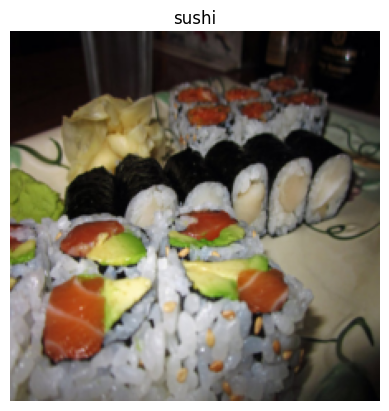

In [7]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## Replicating ViT: overview

## Split data into patches and creating a class, position and patch embadding

layers=>input=>function=>output

In [8]:
height =224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches 
number_of_pathces = int((height * width) / patch_size**2)
number_of_pathces

196

In [9]:
embedding_layer = (height, width, color_channels)

embedding_layer_output_shape = (number_of_pathces, patch_size**2 * color_channels)

print(f'input shape (single 2D image): {embedding_layer}')
print(f'output shape (1D sequence of images): {embedding_layer_output_shape}')

input shape (single 2D image): (224, 224, 3)
output shape (1D sequence of images): (196, 768)


## Turning a single image into pathces

In [10]:
image.shape

torch.Size([3, 224, 224])

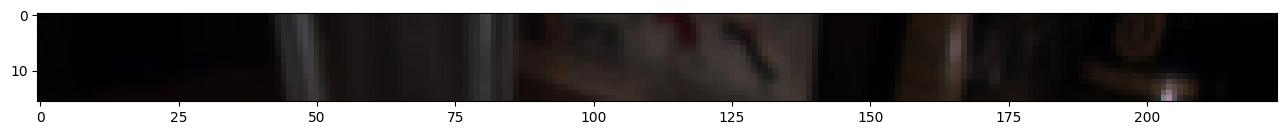

In [12]:
image_permuted = image.permute(1,2,0)

# index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


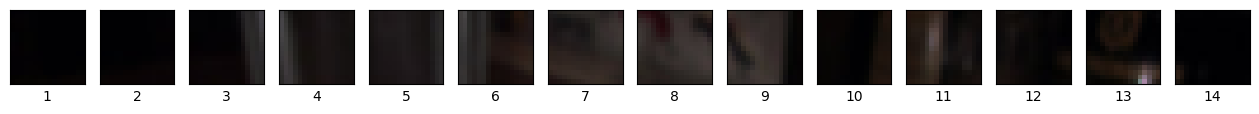

In [18]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'Image size must be divisable by patch size'
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of pathces in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

number of pathes per row: 14.0
Number of patches per column: 14.0
Total pathces: 196.0
Patch size: 16 pixels x 16 pixels


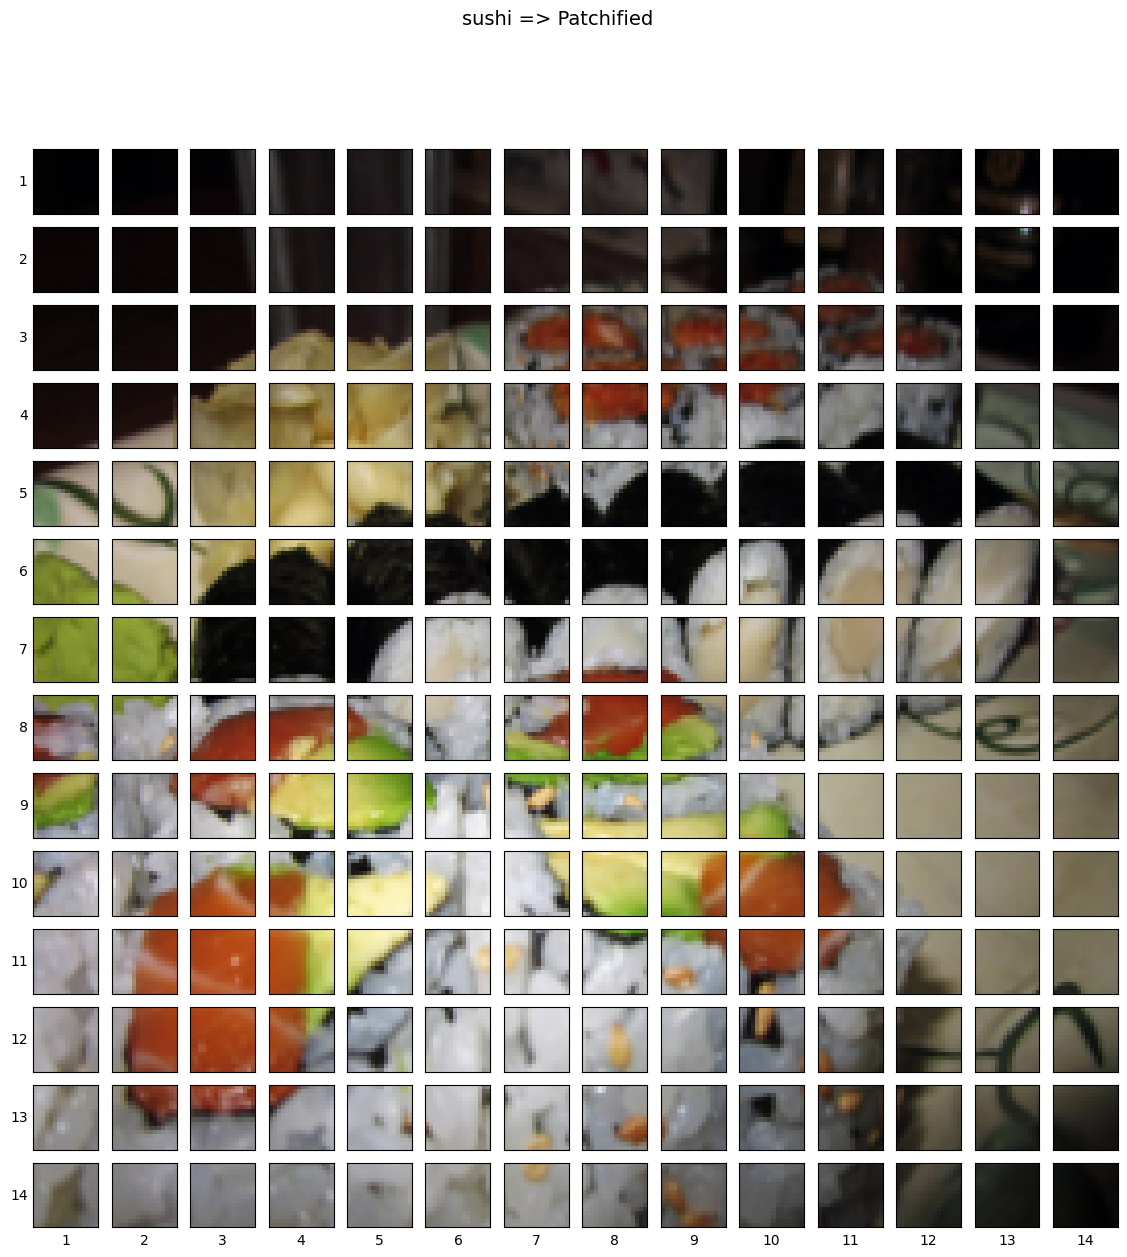

In [22]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'image size must be divisable by patch size'
print(f'number of pathes per row: {num_patches}\nNumber of patches per column: {num_patches}\nTotal pathces: {num_patches*num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a seriese of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(num_patches, num_patches))

for i, patch_height in enumerate(range(0,img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                        patch_width:patch_width+patch_size,
                        :])
        # Set up label info for each subplot
        axs[i,j].set_ylabel(i+1,
                            rotation='horizontal',
                            horizontalalignment='right',
                            verticalalignment='center')
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

fig.suptitle(f'{class_names[label]} => Patchified', fontsize=14)
plt.show()

## Creating image patches and turning them into patch embaddings

In [23]:
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

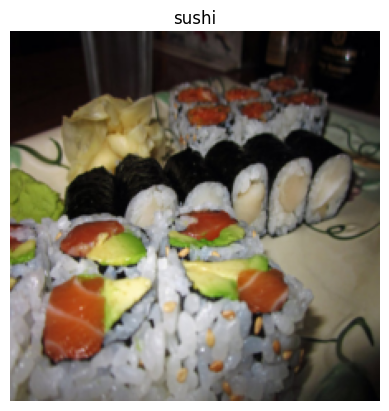

In [24]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [26]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [27]:
image_out_of_conv.requires_grad

True

showing random convolutional feature maps from indexes: [393, 638, 222, 121, 215]


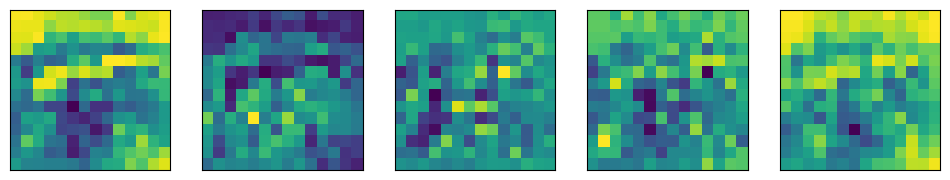

In [29]:
# plot random convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f'showing random convolutional feature maps from indexes: {random_indexes}')

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :,:]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [30]:
single_image_map = image_out_of_conv[:,0,:,:]
single_image_map, single_image_map.requires_grad

(tensor([[[-0.0221, -0.0210, -0.0362,  0.0318,  0.0029,  0.0473,  0.0122,
            0.0051,  0.1027, -0.0533,  0.0503, -0.0060, -0.0496, -0.0116],
          [-0.0136, -0.0147, -0.0323,  0.0114,  0.0018,  0.0305,  0.0302,
            0.0162,  0.0473, -0.0173, -0.0278,  0.0066,  0.0682, -0.0204],
          [-0.0129, -0.0109, -0.0546,  0.1283, -0.0361, -0.0076,  0.0795,
            0.0909,  0.1492,  0.0323,  0.0349,  0.0386,  0.0117, -0.0237],
          [-0.0121, -0.0510,  0.0134,  0.1277,  0.1399,  0.1126,  0.0766,
            0.0455,  0.0267,  0.0425,  0.1810,  0.1383,  0.0572,  0.0227],
          [-0.0723,  0.1873,  0.1530,  0.0973,  0.2385,  0.0496,  0.0134,
            0.1454,  0.0419,  0.0365,  0.0425, -0.0159,  0.0751,  0.1350],
          [ 0.0866,  0.1682,  0.1090,  0.1273,  0.0169,  0.0738,  0.0176,
           -0.0078,  0.0358,  0.2596,  0.0577,  0.1719,  0.2498,  0.0937],
          [-0.0217,  0.0621,  0.0605,  0.0973, -0.0202,  0.2423,  0.0778,
            0.2226,  0.0097,  0.

## Flattening patch embaddings

In [32]:
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

original image shape: torch.Size([3, 224, 224])
Image feature map (pathces) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: tensor([[[-0.0221, -0.0210, -0.0362,  ...,  0.0375,  0.0205, -0.0031],
         [-0.0222, -0.0233, -0.0625,  ..., -0.1716, -0.0792, -0.0474],
         [-0.0311, -0.0268, -0.0244,  ..., -0.0304, -0.0224, -0.0412],
         ...,
         [ 0.0289,  0.0228, -0.0195,  ...,  0.0113,  0.0351,  0.0277],
         [-0.0270, -0.0256, -0.0329,  ..., -0.1317, -0.0622, -0.0447],
         [-0.0086,  0.0006,  0.0208,  ...,  0.1098,  0.0714,  0.0242]]],
       grad_fn=<ViewBackward0>)


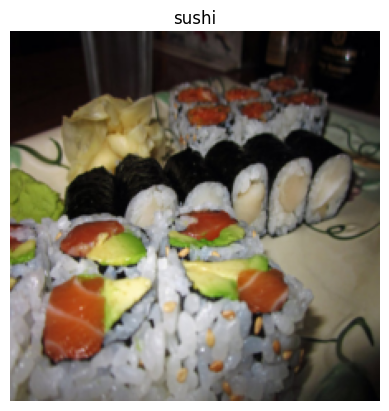

In [33]:
# Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'original image shape: {image.shape}')

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'Image feature map (pathces) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened}')

In [34]:
# rearrange output of flatten layer
print(f'{image_out_of_conv_flattened.permute(0,2,1).shape}')

torch.Size([1, 196, 768])
